# Generación de un modelo a partir de uno modelo pre-entrenado
---
**Configuración General del Entorno de Trabajo**

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [12]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'# carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


---
### Preparación de Dataset

In [13]:
import zipfile
import os

# Ruta al archivo ZIP en Google Drive
zip_path = os.path.join(DATOS_DIR, 'FlowersX16.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = LOCAL_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: ./DATOS/


### Preparación de los datos

Se preparan los datos para entrenar el modelo de clasificación de imágenes de flores.
Se define un generador de imágenes con una división de datos de entrenamiento y validación.

Se  especifica el directorio de imágenes, el tamaño de entrada de las imágenes, el tamaño de los lotes y la proporción de división entre entrenamiento y validación.
Es importante tener en cuenta que las imágenes deben tener 224x224x3 por la entrada del modelo pre-entrenado y no deben estar escaladas ya que la primer capa realiza el escalado.

Luego se crean dos iteradores de datos: uno para el entrenamiento y otro para la validación. Ambos iteradores cargan imágenes desde el directorio especificado, ajustan las imágenes al tamaño requerido por el modelo preentrenado, y las organizan en lotes del tamaño definido. El iterador de entrenamiento (**train_iter**) utiliza el subconjunto de datos de entrenamiento (**subset='training'**) según la división especificada, mientras que el iterador de validación (**valid_iter**) utiliza el subconjunto de datos de validación(**subset='validation'**).

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tf_util import EpochTiming
import tensorflow as tf

# Constantes para arquitectura, generación de datos y entrenamiento/validación
IMG_SIZE = (96, 96)  # Tamaño de la imagen de entrada (se elimina el canal de la tupla)
N_CLASSES = 16       # Cantidad de clases a identificar
LOTES = 256          # Tamaño de lotes para entrenamiento y testeo
ALFA = 0.00001       # Tasa de aprendizaje
EPOCAS = 100         # Cantidad de épocas a entrenar como máximo
PACIENCIA = 10       # Parámetro para parada temprana
VAL_SPLIT = 0.2      # Porcentaje para validación

IMAGES_DIR = LOCAL_DIR + 'FlowersX16/'

# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        # Preprocesamiento específico para MobileNetV3
        image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
        return image, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_iter = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_iter = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


## Santi: ¿Cual es la diferencia entre global y flatten?

### Construcción del Modelo

Compila y entrena un modelo de clasificación de flores utilizando MobileNetV3Small. Se carga el modelo **MobileNetV3Small** con pesos preentrenados en ImageNet, excluyendo la capa superior, y se congelan las capas iniciales para usarlas solo como extractoras de características.

Se construye el modelo agregando una capa de **GlobalAveragePooling2D** para reducir la cantidad de parámetros y prevenir el sobreajuste. También se podría usar una capa **Flatten** que Convierte la entrada multidimensional en un vector unidimensional,
preserva toda la información espacial, pero aumentando significativamente el número de parámetros. Esto puede llevar a un sobreajuste más fácilmente, para conjuntos de datos pequeños.

Se configuran callbacks de parada temprana y de gráficos de evolución del entrenamiento.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt

!pip install livelossplot
from livelossplot import PlotLossesKeras

# constantes para arquitectura, generación datos y entrenamiento/validacion
N_CLASSES = 16          # cantidad de clases a identificar
ALFA = 0.001            # tasa de entrenamiento
EPOCAS = 100            # cantidad de epocas a entrenar como máximo
PACIENCIA = 15          # parámetro para parada temprana

# obtiene la arquitectura para el modelo pre-entrenado
feature_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))

# congela capas iniciales, no las entrena, las usa para extracciones de características
for layer in feature_model.layers:
    layer.trainable = False

# Construye el modelo con el método funcional
# GlobalAverage promedia la información de cada canal a 1 valor. Reduce significativamente la cantidad de parametros,
# ayuda a prevenir el sobreajuste y es invariante a la traslacion.
layers = GlobalAveragePooling2D() (feature_model.output)
layers = Dense(512)(layers)
layers = BatchNormalization()(layers)
layers = LeakyReLU()(layers)
layers = Dropout(0.5)(layers)
output = Dense(N_CLASSES, activation='softmax')(layers)

model = Model(inputs=feature_model.input, outputs=output)

#Optimizer
opt = Adam(learning_rate=ALFA)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 96, 96, 3) │          0 │ input_layer_2[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 48, 48,    │        432 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 48, 48,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 48, 48,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 49, 49,    │          0 │ activation_36[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_28[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1, 1, 16)  │          0 │ re_lu_29[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 24, 24,    │          0 │ re_lu_28[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,244,800 (4.75 MB)

 Trainable params: 304,656 (1.16 MB)

 Non-trainable params: 940,144 (3.59 MB)

### Entrenamiento y Evolución

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.4440 - loss: 1.8992 - val_accuracy: 0.7916 - val_loss: 0.6824
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7466 - loss: 0.7759 - val_accuracy: 0.8437 - val_loss: 0.5182
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7721 - loss: 0.6724 - val_accuracy: 0.8526 - val_loss: 0.4745
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8018 - loss: 0.5973 - val_accuracy: 0.8713 - val_loss: 0.4012
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8223 - loss: 0.5371 - val_accuracy: 0.8755 - val_loss: 0.3894
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8376 - loss: 0.4973 - val_accuracy: 0.8783 - val_loss: 0.3782
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8482 - loss: 0.4653 - val_accuracy: 0.8809 - val_loss: 0.3753
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8605 - loss: 0.4194 - val_accuracy: 

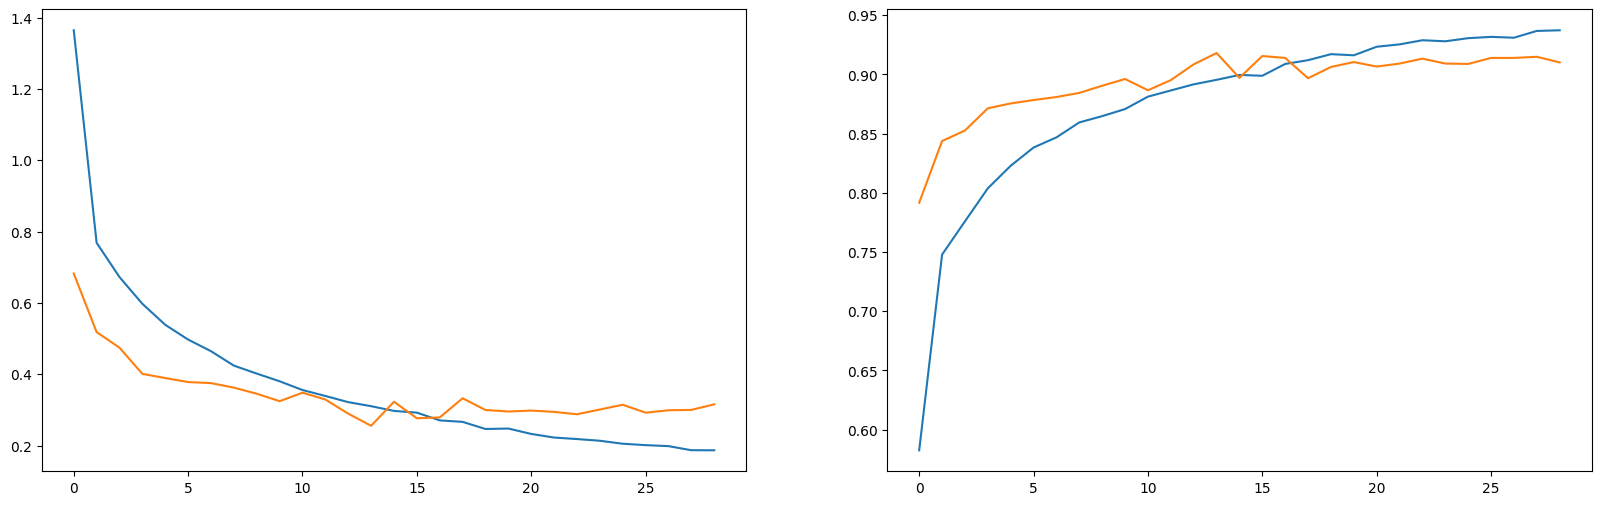

<Figure size 640x480 with 0 Axes>

In [16]:
# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

H = model.fit(
    train_iter,
    validation_data=valid_iter,
    epochs=EPOCAS,
    callbacks=[early_stop])

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

In [17]:
model.evaluate(train_iter)
model.evaluate(valid_iter)

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9373 - loss: 0.2183
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9296 - loss: 0.2314


[0.2556729018688202, 0.9180431962013245]